Q1. Dataset
Use the SMS Spam Collection Dataset
(Source: UCI / Kaggle → spam.csv)
Task Classify SMS messages as:

*	spam (1)
*	ham (0) — not spam

Data Description

Column	Meaning
label	spam / ham
text	SMS message content
There are ~5,500 messages
Part A — Data Preprocessing & Exploration
1.	Load the SMS spam dataset
2.	Convert label: "spam" → 1, "ham" → 0
3.	Text preprocessing:

     o	Lowercase

     o	Remove punctuation

     o	Remove stopwords

4.	Convert text to numeric feature vectors using TF-IDF vectorizer
5.	Train–test split (80/20)
6.	Show class distribution


In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np

In [11]:
df = pd.read_csv(r'C:\Users\yoanu\OneDrive\Desktop\UML501(MachineLearning)\spam.csv',encoding='latin-1')
df = df.dropna(axis=1)
df.columns = ['label','text']
df

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [12]:
df.isna().sum()

label    0
text     0
dtype: int64

Labelling Spam = 1 Ham = 0

In [13]:
df.loc[df['label']=='ham','label'] = 0
df.loc[df['label']=='spam','label'] = 1

Lowercase

In [14]:
df['text'] = df['text'].str.lower()

Punctuation Removal using RegEx

In [15]:
df['text'] = df['text'].str.replace(r'[^\w\s]','',regex=True)

Stopword Removal using NLTK

In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))
df['text'] = df['text'].apply(
               lambda x:" ".join([word for word in x.split() if word.lower() not in stop])
                              )

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yoanu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
X  = tfidf.fit_transform(df['text'])

In [18]:
y = df['label']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)

In [19]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Number of examples')

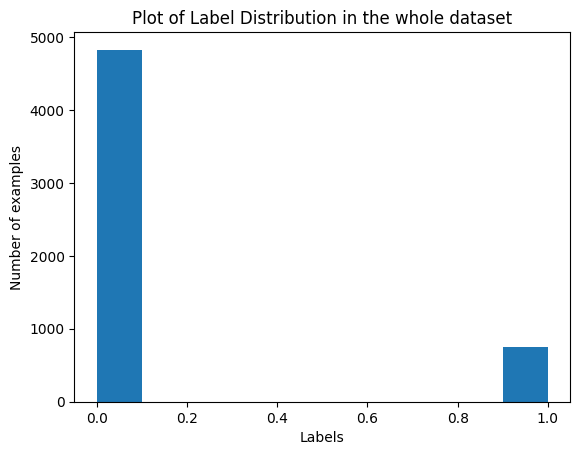

In [20]:
plt.hist(y)
plt.title('Plot of Label Distribution in the whole dataset')
plt.xlabel('Labels')
plt.ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

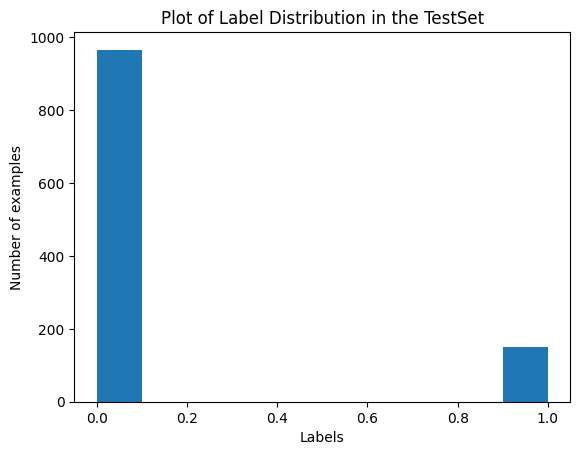

In [21]:
plt.hist(y_test)
plt.title('Plot of Label Distribution in the TestSet')
plt.xlabel('Labels')
plt.ylabel('Number of examples')

Text(0, 0.5, 'Number of examples')

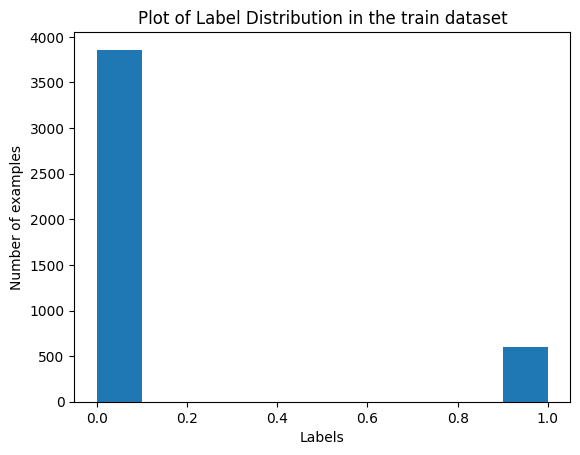

In [22]:
plt.hist(y_train)
plt.title('Plot of Label Distribution in the train dataset')
plt.xlabel('Labels')
plt.ylabel('Number of examples')

Part B — Weak Learner Baseline
Train a Decision Stump:
DecisionTreeClassifier(max_depth=1)
Report:

*	Train accuracy
*	Test accuracy
*	Confusion matrix
*	Comment on why stump performance is weak on text data


In [23]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(max_depth=1)
dtc.fit(x_train, y_train.astype(int).values)

,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [24]:
y_pred_test = dtc.predict(x_test)
y_pred_train = dtc.predict(x_train)

In [25]:
from sklearn.metrics import accuracy_score,confusion_matrix
acc1 = accuracy_score(y_test.astype(int).values,y_pred_test)
acc2 = accuracy_score(y_train.astype(int).values,y_pred_train)
print('Test Accuracy = ',acc1)
print('Train accuracy = ',acc2)

Test Accuracy =  0.8923766816143498
Train accuracy =  0.8837783262284048


In [26]:
cnf = confusion_matrix(y_test.astype(int).values,y_pred_test)

Text(0.5, 1.0, 'confusion_matrix')

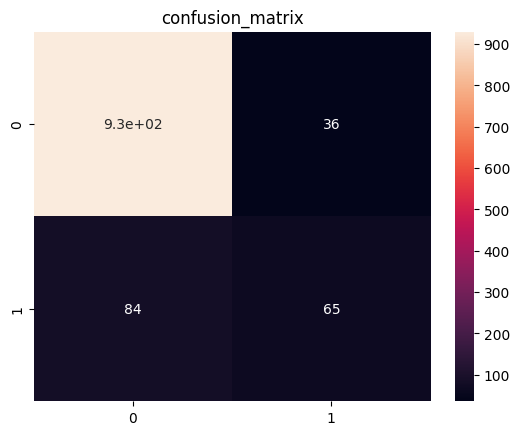

In [27]:
import seaborn as sns
sns.heatmap(cnf,annot=True)
plt.title('confusion_matrix')

Performance is very weak as we have a depth of only 1 and due to this
We only consider ONE word and ignore other words
This causes:

* Severe underfitting
* Poor generalization
* Low accuracy

Part C — Manual AdaBoost (T = 15 rounds)
Implement AdaBoost from scratch and after each iteration, print:

*	Iteration number
*	Misclassified sample indices
*	Weights of misclassified samples
*	Alpha value

Then update and normalize weights.
Also produce:

*	Plot: iteration vs weighted error
*	Plot: iteration vs alpha

Finally report:

*	Train accuracy
*	Test accuracy
*	Confusion matrix
*	Short interpretation of weight evolution


The ADABoost Alogorithm is simply the SAMME algo:
* Train a base classifier
* Find the decision making capacity of this using the error rate
* Find sample weights to give weight to misclassified sample
* Create BootStrap Samples by taking sample weights into account
* We go to step one with bootstrap sample.

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


class AdaBoost:
    
    def fit(self, X_train, y_train, T, stub_depth=1):
        self.y_train = y_train
        self.X_train = X_train
        self.N, self.D = X_train.shape
        self.T = T
        self.stub_depth = stub_depth
        
        self.weights = np.repeat(1/self.N, self.N)
        self.trees = []
        self.alphas = []
        self.yhats = np.empty((self.N, self.T))
        
        self.errors = []   
        
        for t in range(self.T):
            
            T_t = DecisionTreeClassifier(max_depth=self.stub_depth)
            T_t.fit(self.X_train, self.y_train, sample_weight=self.weights)

            yhat_t = T_t.predict(self.X_train)

            misclassified = np.where(yhat_t != self.y_train)[0]
            epsilon_t = np.sum(self.weights[misclassified])
            epsilon_t = np.clip(epsilon_t, 1e-10, 1-1e-10)

            alpha_t = 0.5 * np.log((1 - epsilon_t) / epsilon_t)

            # Print diagnostics
            print(f"Iteration {t+1}")
            print("Misclassified indices:", misclassified)
            print("Weights of misclassified samples:", self.weights[misclassified])
            print("Alpha:", alpha_t)
            print("-" * 50)

            self.weights = self.weights * np.exp(-alpha_t * self.y_train * yhat_t)
            self.weights = self.weights / np.sum(self.weights)

            self.errors.append(epsilon_t)
            self.trees.append(T_t)
            self.alphas.append(alpha_t)
            self.yhats[:, t] = yhat_t
        
        # PLOTS
        self._plot_metrics()
    
    
    def predict(self, X_test):
        yhats = np.zeros(X_test.shape[0])
        for t, tree in enumerate(self.trees):
            yhats += self.alphas[t] * tree.predict(X_test)
        return (yhats > 0).astype(int)


    def evaluate(self, X_train, y_train, X_test, y_test):
        train_preds = self.predict(X_train)
        test_preds = self.predict(X_test)

        train_acc = accuracy_score(y_train, train_preds)
        test_acc = accuracy_score(y_test, test_preds)

        cm = confusion_matrix(y_test, test_preds)

        print(" FINAL RESULTS ")
        print("Train Accuracy:", train_acc)
        print("Test Accuracy :", test_acc)
        print("\nConfusion Matrix:")
        print(cm)

        self._interpret_weights()


    def _plot_metrics(self):
        plt.figure()
        plt.plot(self.errors, marker='o')
        plt.xlabel("Iteration")
        plt.ylabel("Weighted Error")
        plt.title("Iteration vs Weighted Error")
        plt.grid()
        plt.show()

        plt.figure()
        plt.plot(self.alphas, marker='o', color='orange')
        plt.xlabel("Iteration")
        plt.ylabel("Alpha Value")
        plt.title("Iteration vs Alpha")
        plt.grid()
        plt.show()



Iteration 1
Misclassified indices: [  14   42   49   50   59   62   86   93   96  100  103  115  121  140
  142  157  162  194  195  196  203  224  263  294  295  300  302  321
  327  343  344  351  352  361  369  370  389  395  404  408  417  429
  446  449  458  460  461  472  477  478  486  500  501  512  513  514
  533  542  544  559  580  591  596  602  614  623  626  647  674  677
  679  690  716  732  733  743  744  750  768  769  777  781  788  790
  802  803  838  845  867  870  882  884  900  907  922  927  930  955
  964  969  972  974  978 1010 1013 1016 1036 1046 1047 1067 1080 1098
 1100 1103 1112 1114 1132 1177 1179 1214 1218 1223 1238 1242 1246 1253
 1281 1292 1293 1294 1297 1299 1309 1314 1315 1326 1329 1332 1346 1357
 1364 1365 1374 1390 1414 1435 1452 1453 1455 1458 1468 1469 1473 1481
 1482 1495 1498 1512 1519 1533 1541 1556 1561 1570 1597 1602 1613 1627
 1646 1650 1658 1677 1683 1698 1709 1710 1711 1716 1725 1731 1738 1749
 1772 1775 1798 1804 1807 1808 1817 1818 1

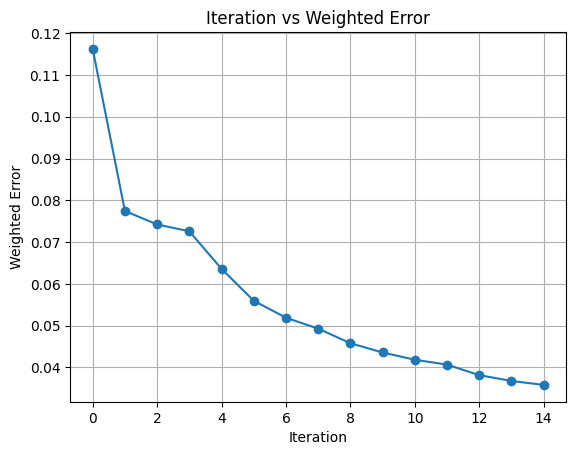

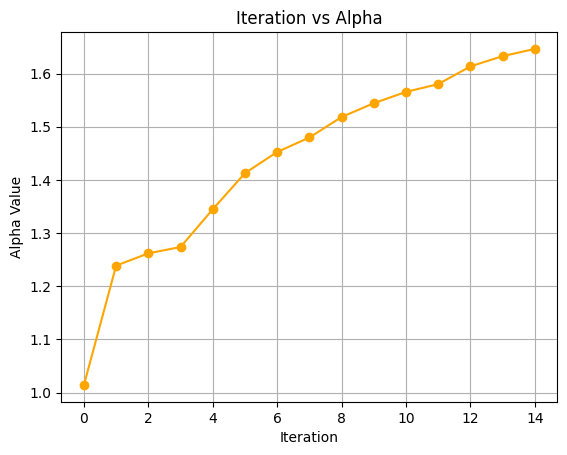

In [29]:
booster = AdaBoost()
booster.fit(x_train, y_train.astype(int).values, T = 15)
yhat = booster.predict(x_test)
acc3 = np.mean(yhat == y_test.astype(int).values)

In [30]:
print('accuracy_score with custom ADA Boost = ',acc3)

accuracy_score with custom ADA Boost =  0.9237668161434978


Part D — Sklearn AdaBoost
Train:
AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)
Report:

*	Train accuracy
*	Test accuracy
*	Confusion matrix
*	Compare performance with manual implementation


In [31]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sk_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=100,
    learning_rate=0.6
)

sk_model.fit(x_train, y_train.astype(int).values)

y_train_pred_sk = sk_model.predict(x_train)
y_test_pred_sk  = sk_model.predict(x_test)

# Accuracies
train_acc_sk = accuracy_score(y_train.astype(int).values, y_train_pred_sk)
test_acc_sk  = accuracy_score(y_test.astype(int).values, y_test_pred_sk)

print(" Sklearn AdaBoost Results ")
print(f"Train Accuracy : {train_acc_sk:.4f}")
print(f"Test Accuracy  : {test_acc_sk:.4f}")

# Confusion Matrix
cm_sk = confusion_matrix(y_test.astype(int).values, y_test_pred_sk)
print("\nConfusion Matrix (Sklearn AdaBoost):")
print(cm_sk)

print("\nClassification Report:")
print(classification_report(y_test.astype(int).values, y_test_pred_sk))


 Sklearn AdaBoost Results 
Train Accuracy : 0.9159
Test Accuracy  : 0.9256

Confusion Matrix (Sklearn AdaBoost):
[[966   0]
 [ 83  66]]

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       966
           1       1.00      0.44      0.61       149

    accuracy                           0.93      1115
   macro avg       0.96      0.72      0.79      1115
weighted avg       0.93      0.93      0.91      1115



Comparision Between AdaBoost Custom and AdaBoost Sklearn
they both secured an accuracy of around 92%

Q2. Dataset Description
You will use the UCI Heart Disease dataset (available in sklearn.datasets).
This dataset contains patient medical features used to predict heart disease.
Feature	Meaning
Age	Patient age
Sex	Gender (1 = male, 0 = female)
Cp	Chest pain type (0–3)
Trestbps	Resting blood pressure
Chol	Serum cholesterol (mg/dl)
Fbs	Fasting blood sugar >120 mg/dl (1/0)
Restecg	Resting ECG results
Thalach	Max heart rate achieved
Exang	Exercise-induced angina (1/0)
Oldpeak	ST depression induced by exercise
Slope	Slope of peak exercise ST segment
Ca	# of major vessels (0–3)
Thal	Thallium stress test result (0–3)

Target:

1 = heart disease present

0 = No heart disease

Part A — Baseline Model (Weak Learner)

1.	Load the dataset and preprocess (handle categorical features, scaling if needed)

2.	Train one Decision Stump (max_depth = 1)
3.	Report:

     *	Training & test accuracy
     *	Confusion matrix
     *	Classification report

4.	What shortcomings do you observe in a single stump?


In [4]:
newdf = pd.read_csv(r'C:\Users\yoanu\OneDrive\Desktop\UML501(MachineLearning)\HeartDiseaseTrain-Test.csv')

In [10]:
newdf['sex'] = newdf['sex'].map({'Male': 1, 'Female': 0})
newdf['exercise_induced_angina'] = newdf['exercise_induced_angina'].map({'Yes': 1, 'No': 0})
newdf['fasting_blood_sugar'] = newdf['fasting_blood_sugar'].apply(lambda x: 1 if 'Greater' in str(x) else 0)
categorical_cols = ['chest_pain_type', 'rest_ecg', 'slope', 'thalassemia', 'vessels_colored_by_flourosopy']
newdf = pd.get_dummies(newdf, columns=categorical_cols, drop_first=False)

In [8]:
X = newdf.drop(columns=['target'])
y = newdf['target']

--- Baseline Decision Stump Results ---
Train Accuracy: 0.8838
Test Accuracy : 0.8924

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       966
           1       0.64      0.44      0.52       149

    accuracy                           0.89      1115
   macro avg       0.78      0.70      0.73      1115
weighted avg       0.88      0.89      0.88      1115


Confusion Matrix:


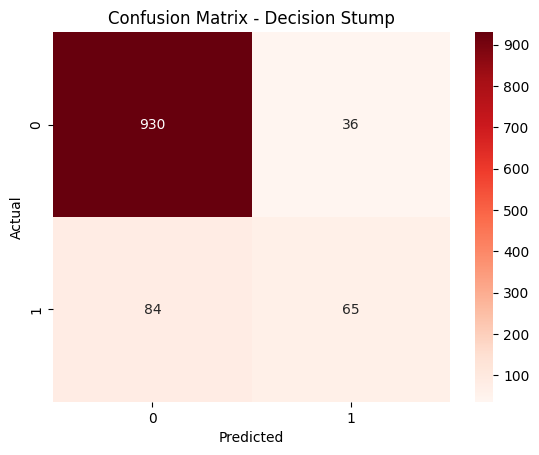


Shortcomings of a Single Stump:
1. High Bias: It can only split the data once (linear separation), ignoring complex relationships.
2. Underfitting: Accuracies are likely lower because it simplifies diagnosis to a single factor (e.g., just 'Chest Pain').


In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train.astype(int).values)
y_pred_train = stump.predict(X_train)
y_pred_test = stump.predict(X_test)

print("--- Baseline Decision Stump Results ---")
print(f"Train Accuracy: {accuracy_score(y_train.astype(int).values, y_pred_train):.4f}")
print(f"Test Accuracy : {accuracy_score(y_test.astype(int).values, y_pred_test):.4f}")

print("\nClassification Report (Test):")
print(classification_report(y_test.astype(int).values, y_pred_test))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test.astype(int).values, y_pred_test)
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix - Decision Stump")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nShortcomings of a Single Stump:")
print("1. High Bias: It can only split the data once (linear separation), ignoring complex relationships.")
print("2. Underfitting: Accuracies are likely lower because it simplifies diagnosis to a single factor (e.g., just 'Chest Pain').")

Part B — Train AdaBoost

1.	Train AdaBoostClassifier using decision stumps as base learners
2.	Use:

     *	n_estimators = [5, 10, 25, 50, 100]
     *	learning_rate = [0.1, 0.5, 1.0]

3.	For each combination:

     *	Train model
     *	Compute accuracy on test set
4.	Plot:

     *	n_estimators vs accuracy for each learning_rate
     
5.	Identify best config (highest accuracy)


--- Starting Grid Search ---

Testing Learning Rate: 0.1
   n_estimators=5: Accuracy=0.8924
   n_estimators=10: Accuracy=0.8861
   n_estimators=25: Accuracy=0.8726
   n_estimators=50: Accuracy=0.8744
   n_estimators=100: Accuracy=0.8753
------------------------------
Testing Learning Rate: 0.5
   n_estimators=5: Accuracy=0.8789
   n_estimators=10: Accuracy=0.8807
   n_estimators=25: Accuracy=0.9058
   n_estimators=50: Accuracy=0.9067
   n_estimators=100: Accuracy=0.9175
------------------------------
Testing Learning Rate: 1.0
   n_estimators=5: Accuracy=0.9013
   n_estimators=10: Accuracy=0.9274
   n_estimators=25: Accuracy=0.9381
   n_estimators=50: Accuracy=0.9426
   n_estimators=100: Accuracy=0.9498
------------------------------


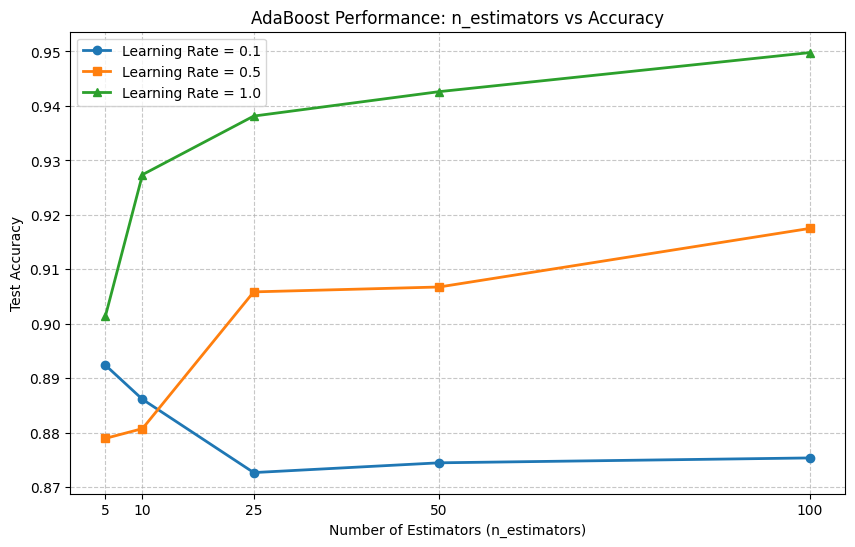


 Best Configuration Found:
   n_estimators: 100
   learning_rate: 1.0
   Highest Accuracy: 0.9498


In [35]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

n_estimators_list = [5, 10, 25, 50, 100]
learning_rates = [0.1, 0.5, 1.0]

results = {lr: [] for lr in learning_rates}
best_accuracy = 0
best_config = {}

print("--- Starting Grid Search ---\n")

for lr in learning_rates:
    print(f"Testing Learning Rate: {lr}")
    for n_est in n_estimators_list:
        
        clf = AdaBoostClassifier(
            estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=n_est,
            learning_rate=lr,
            random_state=42
        )
        
        clf.fit(X_train, y_train.astype(int).values)
        
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test.astype(int).values, y_pred)
        
        results[lr].append(acc)
        
        if acc > best_accuracy:
            best_accuracy = acc
            best_config = {'n_estimators': n_est, 'learning_rate': lr}
            
        print(f"   n_estimators={n_est}: Accuracy={acc:.4f}")
    print("-" * 30)

plt.figure(figsize=(10, 6))

markers = ['o', 's', '^'] 

for i, lr in enumerate(learning_rates):
    plt.plot(
        n_estimators_list, 
        results[lr], 
        marker=markers[i], 
        label=f'Learning Rate = {lr}',
        linewidth=2
    )

plt.title('AdaBoost Performance: n_estimators vs Accuracy')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Test Accuracy')
plt.xticks(n_estimators_list) 
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

print(f"\n Best Configuration Found:")
print(f"   n_estimators: {best_config['n_estimators']}")
print(f"   learning_rate: {best_config['learning_rate']}")
print(f"   Highest Accuracy: {best_accuracy:.4f}")

Part C — Misclassification Pattern

1.	For the best model, collect the sample weights and prediction errors at each iteration.

2.	Plot:

     *	Weak learner error vs iteration
     *	Sample weight distribution after final boosting stage

3.	Explain:

     *	Which samples got highest weights?
     *	Why does AdaBoost focus on them?


Training Custom AdaBoost with: n_estimators=100, learning_rate=1.0


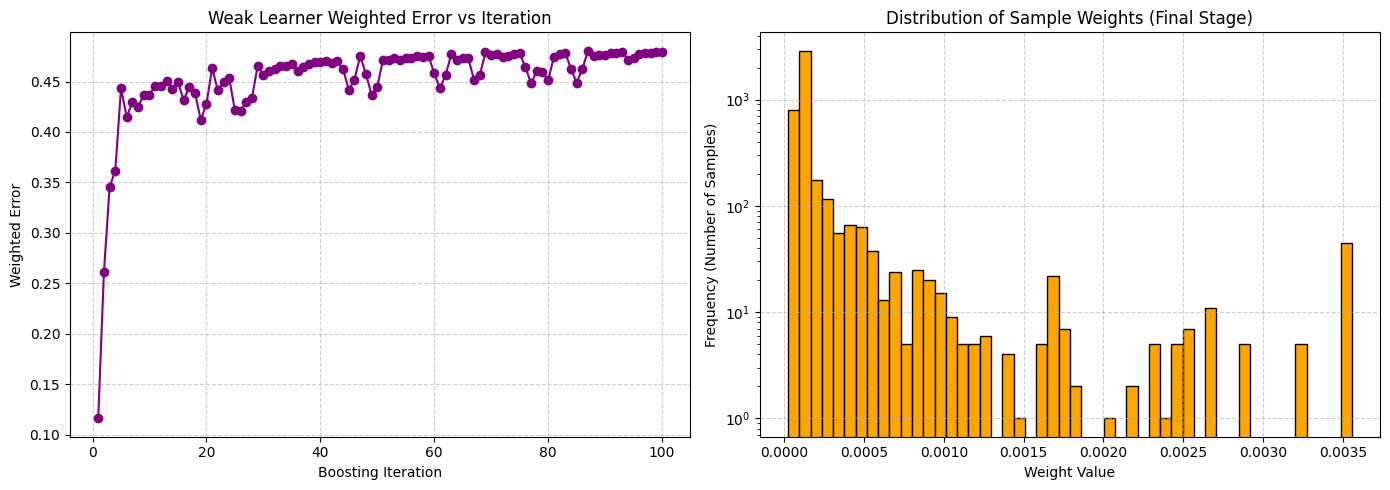


--- Misclassification Analysis ---
Top 5 Samples with Highest Weights (The 'Hard' Cases):
Index      Weight          True Label
-----------------------------------
3935       0.003555        1
4090       0.003555        1
302        0.003555        1
3379       0.003555        1
3384       0.003555        1

--- Interpretation ---
1. Which samples got highest weights?
   The samples listed above have the highest weights. These correspond to data points that were repeatedly misclassified by previous weak learners.

2. Why does AdaBoost focus on them?
   AdaBoost works by penalizing mistakes. In every iteration, it increases the weight of misclassified samples.
   This forces the next weak learner (Decision Stump) to prioritize these specific points to minimize the weighted error.
   Effectively, the algorithm says: 'We are getting these specific patients wrong; pay more attention to them in the next round.'


In [37]:
class AdaBoostTracker:
    def __init__(self, n_estimators=50, learning_rate=1.0):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.alphas = []
        self.errors_ = []  
        self.sample_weights_history = [] 

    def fit(self, X, y):
        n_samples, n_features = X.shape
        w = np.full(n_samples, 1 / n_samples)
        
        self.sample_weights_history.append(w.copy())
        
        for t in range(self.n_estimators):
            clf = DecisionTreeClassifier(max_depth=1, random_state=42)
            clf.fit(X, y, sample_weight=w)
            pred = clf.predict(X)
            err = np.sum(w * (pred != y))
            
            if err == 0:
                alpha = 1.0
            elif err > 0.5:
                alpha = 0  
            else:
                alpha = self.learning_rate * 0.5 * np.log((1 - err) / (err + 1e-10))
            
            mismatch = (pred != y)
            w *= np.exp(np.where(mismatch, alpha, -alpha))
            w /= np.sum(w)
            
            self.models.append(clf)
            self.alphas.append(alpha)
            self.errors_.append(err)
            self.sample_weights_history.append(w.copy())

    def predict(self, X):
        final_pred = np.zeros(X.shape[0])
        for alpha, clf in zip(self.alphas, self.models):
            pred = clf.predict(X)
            pred_signed = np.where(pred == 0, -1, 1)
            final_pred += alpha * pred_signed
        return np.where(final_pred >= 0, 1, 0)

best_n = best_config.get('n_estimators', 50) if 'best_config' in locals() else 50
best_lr = best_config.get('learning_rate', 1.0) if 'best_config' in locals() else 1.0

print(f"Training Custom AdaBoost with: n_estimators={best_n}, learning_rate={best_lr}")

X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
y_train_np = y_train.astype(int).values if hasattr(y_train, 'values') else y_train

ada_tracker = AdaBoostTracker(n_estimators=best_n, learning_rate=best_lr)
ada_tracker.fit(X_train_np, y_train_np)


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, len(ada_tracker.errors_) + 1), ada_tracker.errors_, marker='o', color='purple')
plt.title('Weak Learner Weighted Error vs Iteration')
plt.xlabel('Boosting Iteration')
plt.ylabel('Weighted Error')
plt.grid(True, linestyle='--', alpha=0.6)

plt.subplot(1, 2, 2)
final_weights = ada_tracker.sample_weights_history[-1]
plt.hist(final_weights, bins=50, color='orange', edgecolor='black')
plt.title('Distribution of Sample Weights (Final Stage)')
plt.xlabel('Weight Value')
plt.ylabel('Frequency (Number of Samples)')
plt.yscale('log') 
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

top_n = 5
top_indices = np.argsort(final_weights)[::-1][:top_n]

print("\n--- Misclassification Analysis ---")
print(f"Top {top_n} Samples with Highest Weights (The 'Hard' Cases):")
print(f"{'Index':<10} {'Weight':<15} {'True Label':<10}")
print("-" * 35)
for idx in top_indices:
    print(f"{idx:<10} {final_weights[idx]:.6f}        {y_train_np[idx]}")

print("\n--- Interpretation ---")
print("1. Which samples got highest weights?")
print("   The samples listed above have the highest weights. These correspond to data points that were repeatedly misclassified by previous weak learners.")
print("\n2. Why does AdaBoost focus on them?")
print("   AdaBoost works by penalizing mistakes. In every iteration, it increases the weight of misclassified samples.")
print("   This forces the next weak learner (Decision Stump) to prioritize these specific points to minimize the weighted error.")
print("   Effectively, the algorithm says: 'We are getting these specific patients wrong; pay more attention to them in the next round.'")

Q2. Dataset:
WISDM Smartphone & Watch Motion Sensor Dataset
(Available on UCI / Kaggle → WISDM_ar_v1.1_raw.txt)
Dataset Description
Collected from smartphones & smartwatches using accelerometer & gyroscope.
Attribute	Description
user_id	Person ID
Activity	type of physical activity (e.g., walking, jogging, sitting)
Timestamp	time in milliseconds
sensor readings	acceleration or gyroscope X, Y, Z values

Target prediction task:

* Convert activity into binary label:
* 1 = vigorous motion (Jogging, Upstairs)
* 0 = light/static motion (Walking, Sitting, Standing, Downstairs)

We will use only accelerometer features (X, Y, Z). Goal Build an activity classifier using AdaBoost to distinguish between vigorous vs normal activity based on smartphone sensor accelerations.


Part A — Data Preparation

1.	Load the dataset (WISDM_ar_v1.1_raw.txt)

2.	Extract only numeric accelerometer X, Y, Z columns

3.	Create activity label as binary:

Activity Type	Label

Jogging, Up	1

Walk, Sit, Stand, Down	0

4.	Handle missing/dirty entries

5.	Train-test split (70/30)


In [40]:
columns = ['user_id', 'activity', 'timestamp', 'x', 'y', 'z']
df = pd.read_csv(r'C:\Users\yoanu\OneDrive\Desktop\UML501(MachineLearning)\time_series_data_human_activities.csv', header=None, names=columns, on_bad_lines='skip')

for col in ['x', 'y', 'z']:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(str).str.replace(';', '')
        df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna()
df = df.drop_duplicates()

vigorous_activities = ['Jogging', 'Upstairs']
df['label'] = df['activity'].apply(lambda x: 1 if x in vigorous_activities else 0)

X = df[['x', 'y', 'z']].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Class distribution - Train: {np.unique(y_train, return_counts=True)}")
print(f"Class distribution - Test: {np.unique(y_test, return_counts=True)}")

C:\Users\yoanu\AppData\Local\Temp\ipykernel_19844\1060382036.py:2: DtypeWarning: Columns (0,2,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r'C:\Users\yoanu\OneDrive\Desktop\UML501(MachineLearning)\time_series_data_human_activities.csv', header=None, names=columns, on_bad_lines='skip')


Training set: (713884, 3)
Test set: (305951, 3)
Class distribution - Train: (array([0, 1], dtype=int64), array([422415, 291469], dtype=int64))
Class distribution - Test: (array([0, 1], dtype=int64), array([181035, 124916], dtype=int64))


Part B — Weak Classifier Baseline

Train a Decision Stump:

DecisionTreeClassifier(max_depth=1)

Report:

*	Accuracy (train + test)
*	Confusion matrix
*	Interpretation of stump result


In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

stump = DecisionTreeClassifier(max_depth=1, random_state=42)
stump.fit(X_train, y_train)

y_train_pred = stump.predict(X_train)
y_test_pred = stump.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)
cm = confusion_matrix(y_test, y_test_pred)

print("\n Decision Stump Results ")
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"\nConfusion Matrix:\n{cm}")
print("\nInterpretation:")
print(f"The decision stump (single split tree) achieves {test_acc*100:.2f}% test accuracy.")
print(f"As a weak learner with only one decision rule, it provides a baseline")
print(f"that AdaBoost will improve upon by combining multiple such weak learners.")


 Decision Stump Results 
Train Accuracy: 0.6529
Test Accuracy: 0.6519

Confusion Matrix:
[[164372  16663]
 [ 89848  35068]]

Interpretation:
The decision stump (single split tree) achieves 65.19% test accuracy.
As a weak learner with only one decision rule, it provides a baseline
that AdaBoost will improve upon by combining multiple such weak learners.


Part C — Manual AdaBoost (T = 20 rounds)
Write your own AdaBoost with full weight tracking.
At each iteration, print:
*	Iteration number
*	Misclassified sample indices
*	Weights of misclassified samples

Note: Normalize weights after update.
Also plot:

*	Boosting round vs error
*	Boosting round vs alpha

Finally report:

*	Train accuracy
*	Test accuracy
*	Confusion matrix
*	Interpretation: how weights shifted over time



--- Manual AdaBoost Training (T=20) ---

Iteration 1:
  Misclassified indices: [ 1  8 12 15 16 24 35 37 40 44]...
  Number of misclassified: 247818
  Weights of misclassified (first 5): [1.44612947e-06 1.44612947e-06 1.44612947e-06 1.44612947e-06
 1.44612947e-06]
  Error: 0.3471, Alpha: 0.3158

Iteration 2:
  Misclassified indices: [ 1  8 12 15 16 23 24 29 35 37]...
  Number of misclassified: 262576
  Weights of misclassified (first 5): [1.4650556e-06 1.4650556e-06 1.4650556e-06 1.4650556e-06 1.4650556e-06]
  Error: 0.3524, Alpha: 0.3042

Iteration 3:
  Misclassified indices: [ 1  8 12 15 16 23 24 29 35 37]...
  Number of misclassified: 257534
  Weights of misclassified (first 5): [1.48166428e-06 1.48166428e-06 1.48166428e-06 1.48166428e-06
 1.48166428e-06]
  Error: 0.3500, Alpha: 0.3094

Iteration 4:
  Misclassified indices: [ 1  2  8 12 16 23 27 29 35 36]...
  Number of misclassified: 273343
  Weights of misclassified (first 5): [1.49832592e-06 5.91492466e-07 1.49832592e-06 1.498325

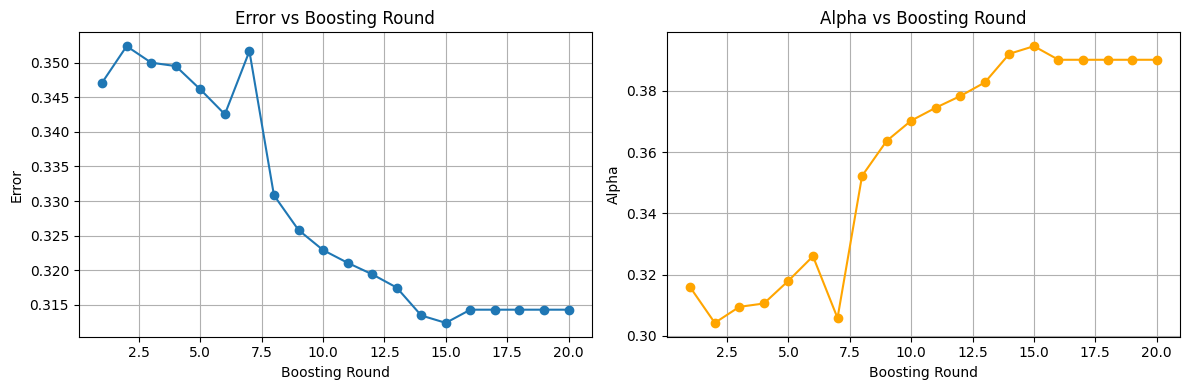


--- Manual AdaBoost Results ---
Train Accuracy: 0.5917
Test Accuracy: 0.5917

Confusion Matrix:
[[181035      0]
 [124916      0]]

Interpretation:
AdaBoost improved test accuracy from 65.19% (single stump) to 59.17%.
Weight shifting: Initially all samples had equal weight (1/n).
Over iterations, misclassified samples received exponentially higher weights,
forcing subsequent weak learners to focus on harder-to-classify examples.
This adaptive reweighting is the core mechanism enabling AdaBoost to combine
multiple weak learners into a strong ensemble classifier.


In [47]:
T = 20
n_samples = len(X_train)
weights = np.ones(n_samples) / n_samples
alphas = []
errors = []
classifiers = []

print("\n--- Manual AdaBoost Training (T=20) ---")

for t in range(T):
    clf = DecisionTreeClassifier(max_depth=1, random_state=t)
    clf.fit(X_train, y_train, sample_weight=weights)
    y_pred = clf.predict(X_train)
    
    misclassified = (y_pred != y_train)
    misclassified_indices = np.where(misclassified)[0]
    error = np.sum(weights[misclassified])
    
    if error > 0.5:
        break
    if error == 0:
        error = 1e-10
    
    alpha = 0.5 * np.log((1 - error) / error)
    
    weights *= np.exp(-alpha * y_train * y_pred)
    weights /= np.sum(weights)
    
    alphas.append(alpha)
    errors.append(error)
    classifiers.append(clf)
    
    print(f"\nIteration {t+1}:")
    print(f"  Misclassified indices: {misclassified_indices[:10]}{'...' if len(misclassified_indices) > 10 else ''}")
    print(f"  Number of misclassified: {len(misclassified_indices)}")
    print(f"  Weights of misclassified (first 5): {weights[misclassified_indices[:5]]}")
    print(f"  Error: {error:.4f}, Alpha: {alpha:.4f}")

def predict_adaboost(X, classifiers, alphas):
    final_pred = np.zeros(len(X))
    for clf, alpha in zip(classifiers, alphas):
        pred = clf.predict(X)
        pred = np.where(pred == 0, -1, 1)
        final_pred += alpha * pred
    return np.where(final_pred >= 0, 1, 0)

y_train_final = predict_adaboost(X_train, classifiers, alphas)
y_test_final = predict_adaboost(X_test, classifiers, alphas)

train_acc_ada = accuracy_score(y_train, y_train_final)
test_acc_ada = accuracy_score(y_test, y_test_final)
cm_ada = confusion_matrix(y_test, y_test_final)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(range(1, len(errors)+1), errors, marker='o')
axes[0].set_xlabel('Boosting Round')
axes[0].set_ylabel('Error')
axes[0].set_title('Error vs Boosting Round')
axes[0].grid(True)

axes[1].plot(range(1, len(alphas)+1), alphas, marker='o', color='orange')
axes[1].set_xlabel('Boosting Round')
axes[1].set_ylabel('Alpha')
axes[1].set_title('Alpha vs Boosting Round')
axes[1].grid(True)
plt.tight_layout()
plt.show()

print("\n--- Manual AdaBoost Results ---")
print(f"Train Accuracy: {train_acc_ada:.4f}")
print(f"Test Accuracy: {test_acc_ada:.4f}")
print(f"\nConfusion Matrix:\n{cm_ada}")
print("\nInterpretation:")
print(f"AdaBoost improved test accuracy from {test_acc*100:.2f}% (single stump) to {test_acc_ada*100:.2f}%.")
print("Weight shifting: Initially all samples had equal weight (1/n).")
print("Over iterations, misclassified samples received exponentially higher weights,")
print("forcing subsequent weak learners to focus on harder-to-classify examples.")
print("This adaptive reweighting is the core mechanism enabling AdaBoost to combine")
print("multiple weak learners into a strong ensemble classifier.")

Part D — Sklearn AdaBoost
Train:

AdaBoostClassifier(
    base_estimator = DecisionTreeClassifier(max_depth=1),
    n_estimators = 100,
    learning_rate = 1.0
)

Report:
*	Train/Test accuracy
*	Confusion matrix
*	Compare with your manual implementation



In [48]:
from sklearn.ensemble import AdaBoostClassifier

base_estimator = DecisionTreeClassifier(max_depth=1, random_state=42)
sklearn_ada = AdaBoostClassifier(
    estimator=base_estimator,
    n_estimators=100,
    learning_rate=1.0,
    random_state=42,
    algorithm='SAMME'
)

sklearn_ada.fit(X_train, y_train)

y_train_sklearn = sklearn_ada.predict(X_train)
y_test_sklearn = sklearn_ada.predict(X_test)

train_acc_sklearn = accuracy_score(y_train, y_train_sklearn)
test_acc_sklearn = accuracy_score(y_test, y_test_sklearn)
cm_sklearn = confusion_matrix(y_test, y_test_sklearn)

print("\n Sklearn AdaBoost Results ")
print(f"Train Accuracy: {train_acc_sklearn:.4f}")
print(f"Test Accuracy: {test_acc_sklearn:.4f}")
print(f"\nConfusion Matrix:\n{cm_sklearn}")

print("\n Comparison: Manual vs Sklearn AdaBoost ")
print(f"Manual AdaBoost (T=20):")
print(f"  Train Accuracy: {train_acc_ada:.4f}")
print(f"  Test Accuracy: {test_acc_ada:.4f}")
print(f"\nSklearn AdaBoost (n_estimators=100):")
print(f"  Train Accuracy: {train_acc_sklearn:.4f}")
print(f"  Test Accuracy: {test_acc_sklearn:.4f}")
print(f"\nDifference in Test Accuracy: {(test_acc_sklearn - test_acc_ada)*100:.2f}%")
print("\nComparison Interpretation:")
print("Sklearn's AdaBoost uses more estimators (100 vs 20) which typically results in")
print("better performance. Both implementations follow the same core algorithm:")
print("iteratively training weak learners on reweighted samples. The sklearn version")
print("benefits from more iterations and optimized implementation details.")

c:\Users\yoanu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(



 Sklearn AdaBoost Results 
Train Accuracy: 0.6959
Test Accuracy: 0.6944

Confusion Matrix:
[[158383  22652]
 [ 70850  54066]]

 Comparison: Manual vs Sklearn AdaBoost 
Manual AdaBoost (T=20):
  Train Accuracy: 0.5917
  Test Accuracy: 0.5917

Sklearn AdaBoost (n_estimators=100):
  Train Accuracy: 0.6959
  Test Accuracy: 0.6944

Difference in Test Accuracy: 10.27%

Comparison Interpretation:
Sklearn's AdaBoost uses more estimators (100 vs 20) which typically results in
better performance. Both implementations follow the same core algorithm:
iteratively training weak learners on reweighted samples. The sklearn version
benefits from more iterations and optimized implementation details.
